In [1]:
import pandas as pd 
import scanpy as sc
import numpy as np  
import matplotlib.pyplot as plt 
import scipy

import os 

# Scanpy config
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.8.2 anndata==0.8.0 umap==0.5.2 numpy==1.21.5 scipy==1.7.3 pandas==1.3.5 scikit-learn==1.0.2 statsmodels==0.13.2 python-igraph==0.9.9 pynndescent==0.5.6


In [2]:
data_path = '../scanpy-tutorials/data/'


adata = sc.read_10x_mtx(
    os.path.join(data_path, 'filtered_gene_bc_matrices/hg19/'),  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)                              # write a cache file for faster subsequent reading

adata

... reading from cache file cache/..-scanpy-tutorials-data-filtered_gene_bc_matrices-hg19-matrix.h5ad


AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

https://anndata-tutorials.readthedocs.io/en/latest/getting-started.html

"in scRNA-seq data, each row corresponds to a cell with a barcode, and each column corresponds to a gene with a gene id. Furthermore, for each cell and each gene we might have additional metadata, like (1) donor information for each cell, or (2) alternative gene symbols for each gene. Finally, we might have other unstructured metadata like color palletes to use for plotting."

In [3]:
# each value in adata.X is a "count" or "expression" of a gene in a cell?
print(adata.X.shape)  # n_cells x n_genes
adata.X

(2700, 32738)


<2700x32738 sparse matrix of type '<class 'numpy.float32'>'
	with 2286884 stored elements in Compressed Sparse Row format>

In [4]:
print(adata.obs_names.shape, adata.obs.index.unique().shape)
adata.obs_names    # cell names, all unique

(2700,) (2700,)


Index(['AAACATACAACCAC-1', 'AAACATTGAGCTAC-1', 'AAACATTGATCAGC-1',
       'AAACCGTGCTTCCG-1', 'AAACCGTGTATGCG-1', 'AAACGCACTGGTAC-1',
       'AAACGCTGACCAGT-1', 'AAACGCTGGTTCTT-1', 'AAACGCTGTAGCCA-1',
       'AAACGCTGTTTCTG-1',
       ...
       'TTTCAGTGTCACGA-1', 'TTTCAGTGTCTATC-1', 'TTTCAGTGTGCAGT-1',
       'TTTCCAGAGGTGAG-1', 'TTTCGAACACCTGA-1', 'TTTCGAACTCTCAT-1',
       'TTTCTACTGAGGCA-1', 'TTTCTACTTCCTCG-1', 'TTTGCATGAGAGGC-1',
       'TTTGCATGCCTCAC-1'],
      dtype='object', length=2700)

In [5]:
print(adata.var_names.shape, adata.var.index.unique().shape)
adata.var_names    # gene names which map onto gene_ids; all unique

(32738,) (32738,)


Index(['MIR1302-10', 'FAM138A', 'OR4F5', 'RP11-34P13.7', 'RP11-34P13.8',
       'AL627309.1', 'RP11-34P13.14', 'RP11-34P13.9', 'AP006222.2',
       'RP4-669L17.10',
       ...
       'KIR3DL2-1', 'AL590523.1', 'CT476828.1', 'PNRC2-1', 'SRSF10-1',
       'AC145205.1', 'BAGE5', 'CU459201.1', 'AC002321.2', 'AC002321.1'],
      dtype='object', length=32738)

In [6]:
# this step seems redundant since gene names are all unique
adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`
adata

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

```
    We expect to see the “usual suspects”, i.e., mitochondrial genes, actin, ribosomal protein, MALAT1. A few spike-in transcripts may also be present here, though if all of the spike-ins are in the top 50, it suggests that too much spike-in RNA was added. A large number of pseudo-genes or predicted genes may indicate problems with alignment. – Davis McCarthy and Aaron Lun
```

normalizing counts per cell
    finished (0:00:00)


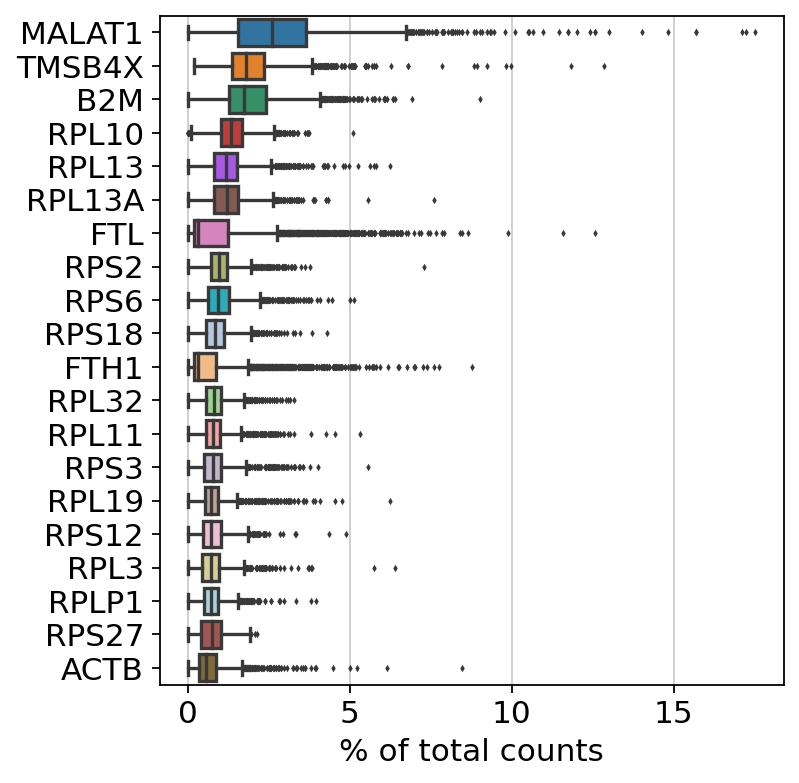

In [7]:
# for each gene (column), find average count per cell (normalising counts to 100) and plot sorted
# MALAT1 has average around 2.5% count in all cells 
sc.pl.highest_expr_genes(adata, n_top=20,)

In [8]:
i = 19154
print(adata.var.iloc[i])
norm_dict = sc.pp.normalize_total(adata, 100., inplace=False)
np.quantile(norm_dict['X'][:, i].A.flatten(), [0, 0.25, 0.5, 0.75, 1.])

gene_ids    ENSG00000251562
Name: MALAT1, dtype: object
normalizing counts per cell
    finished (0:00:00)


array([ 0.        ,  1.55532315,  2.59123313,  3.6363638 , 17.51054955])

In [9]:
# filter out cells with less than 200 genes
# filter out genes which appear in less than 3 cells 
sc.pp.filter_cells(adata, min_genes=200)    # {min|max}_{genes|counts}
sc.pp.filter_genes(adata, min_cells=3)      # {min|max}_{cells|counts}
adata

filtered out 19024 genes that are detected in less than 3 cells


AnnData object with n_obs × n_vars = 2700 × 13714
    obs: 'n_genes'
    var: 'gene_ids', 'n_cells'

In [10]:
print('fewest genes in a cell', adata.obs.n_genes.min())
adata.obs.head()

fewest genes in a cell 212


,n_genes
AAACATACAACCAC-1,781
AAACATTGAGCTAC-1,1352
AAACATTGATCAGC-1,1131
AAACCGTGCTTCCG-1,960
AAACCGTGTATGCG-1,522


In [11]:
print('minimum cells a gene appears in', adata.var.n_cells.min())
adata.var.head()

minimum cells a gene appears in 3


,gene_ids,n_cells
AL627309.1,ENSG00000237683,9
AP006222.2,ENSG00000228463,3
RP11-206L10.2,ENSG00000228327,5
RP11-206L10.9,ENSG00000237491,3
LINC00115,ENSG00000225880,18


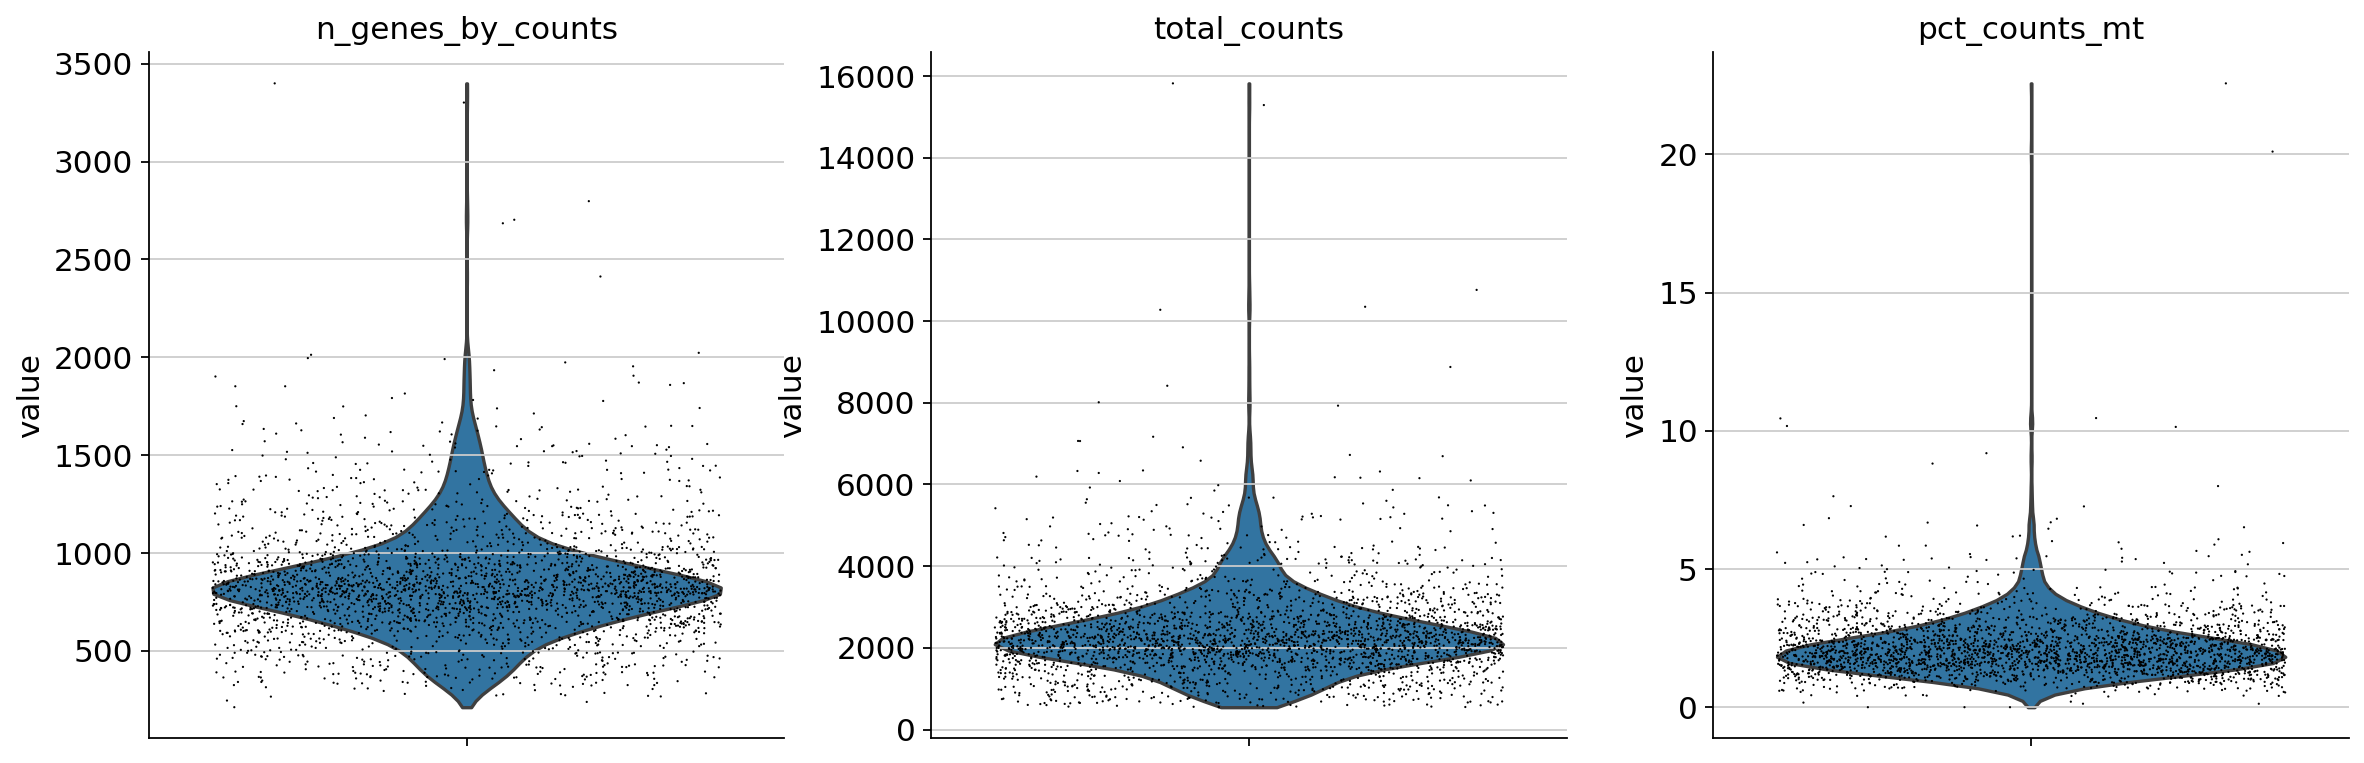

In [12]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
# https://scanpy.readthedocs.io/en/latest/generated/scanpy.pp.calculate_qc_metrics.html#scanpy-pp-calculate-qc-metrics
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True)

In [13]:
adata

AnnData object with n_obs × n_vars = 2700 × 13714
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [14]:
adata.obs.head()

,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt
AAACATACAACCAC-1,781,779,2419.0,73.0,3.017776
AAACATTGAGCTAC-1,1352,1352,4903.0,186.0,3.793596
AAACATTGATCAGC-1,1131,1129,3147.0,28.0,0.889736
AAACCGTGCTTCCG-1,960,960,2639.0,46.0,1.743085
AAACCGTGTATGCG-1,522,521,980.0,12.0,1.224490


In [15]:
(adata.X[0, :] > 0.).sum(), adata.X[0, :].sum(), adata.X[0, adata.var.mt.values].sum(), 73 / 2419 * 100

(779, 2419.0, 73.0, 3.017775940471269)

In [16]:
adata.var.head()

,gene_ids,n_cells,mt,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts
AL627309.1,ENSG00000237683,9,False,9,0.003333,99.666667,9.0
AP006222.2,ENSG00000228463,3,False,3,0.001111,99.888889,3.0
RP11-206L10.2,ENSG00000228327,5,False,5,0.001852,99.814815,5.0
RP11-206L10.9,ENSG00000237491,3,False,3,0.001111,99.888889,3.0
LINC00115,ENSG00000225880,18,False,18,0.006667,99.333333,18.0


In [17]:
adata.X[:, 0].mean(), 1 - adata.X[:, 0].mean(), adata.X[:, 0].sum()

(0.0033333334, 0.996666666585952, 9.0)

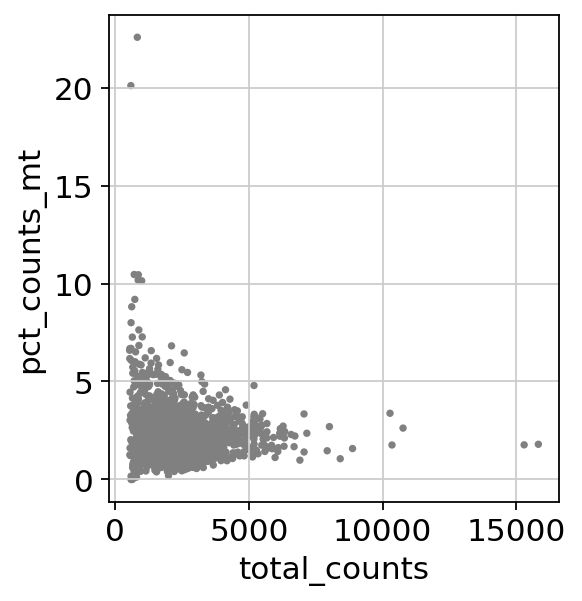

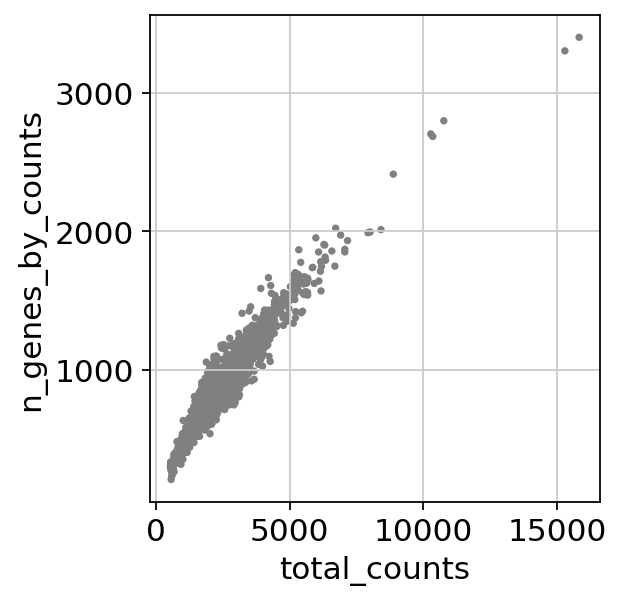

In [18]:
# plot scatter of cells by total gene counts vs percent of mt gene counts
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
# plot scatter of cells by total gene counts vs number of unique genes
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [19]:
# filter out cells with more than 2500 unique genes
# filter out cells with more than 5% mt 
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]

In [20]:
adata

View of AnnData object with n_obs × n_vars = 2638 × 13714
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [21]:
# normalise total count to 10,000 per cell 
sc.pp.normalize_total(adata, target_sum=1e4)

normalizing counts per cell
    finished (0:00:00)


/home/hbl/.local/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [22]:
adata.X[0, :].sum()

9999.966

In [23]:
# log transform counts: log(X + 1)
sc.pp.log1p(adata)

In [24]:
np.quantile(adata.X[0, :].A, [0.5, 0.75, 0.9, 0.95, 1.])

array([0.        , 0.        , 0.        , 1.63587332, 5.75314188])

In [25]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


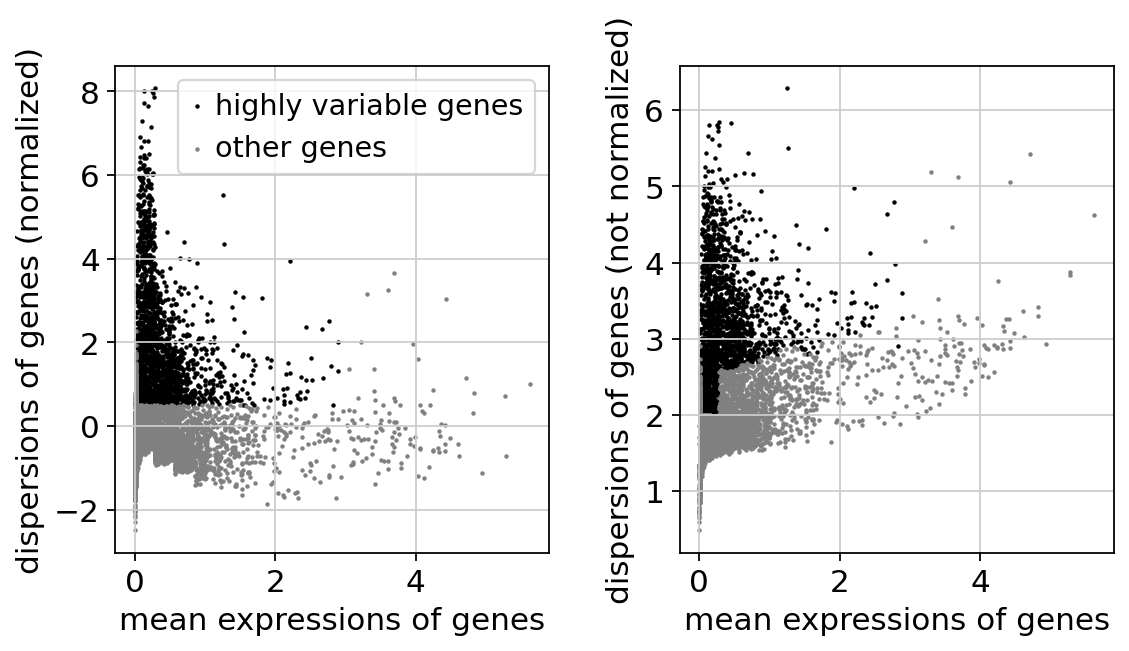

In [26]:
sc.pl.highly_variable_genes(adata)

In [27]:
adata

AnnData object with n_obs × n_vars = 2638 × 13714
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

In [28]:
adata.obs.head()

,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt
AAACATACAACCAC-1,781,779,2419.0,73.0,3.017776
AAACATTGAGCTAC-1,1352,1352,4903.0,186.0,3.793596
AAACATTGATCAGC-1,1131,1129,3147.0,28.0,0.889736
AAACCGTGCTTCCG-1,960,960,2639.0,46.0,1.743085
AAACCGTGTATGCG-1,522,521,980.0,12.0,1.224490


In [29]:
adata.var.head()

,gene_ids,n_cells,mt,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,highly_variable,means,dispersions,dispersions_norm
AL627309.1,ENSG00000237683,9,False,9,0.003333,99.666667,9.0,False,0.013556,1.432845,-0.624328
AP006222.2,ENSG00000228463,3,False,3,0.001111,99.888889,3.0,False,0.004696,1.458631,-0.573416
RP11-206L10.2,ENSG00000228327,5,False,5,0.001852,99.814815,5.0,False,0.005673,1.325459,-0.836359
RP11-206L10.9,ENSG00000237491,3,False,3,0.001111,99.888889,3.0,False,0.002644,0.859264,-1.756848
LINC00115,ENSG00000225880,18,False,18,0.006667,99.333333,18.0,False,0.027437,1.457477,-0.575693


In [30]:
# not too sure what this does, but can get back an AnnData of the object in .raw by calling .raw.to_adata()
adata.raw = adata

In [31]:
# keep highly variable genes? 
adata = adata[:, adata.var.highly_variable]

In [32]:
# Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed. 
# https://scanpy.readthedocs.io/en/latest/generated/scanpy.pp.regress_out.html?highlight=regress_out
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
# Scale the data to unit variance.
sc.pp.scale(adata, max_value=10)

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:00:06)


In [33]:
# PCA 
sc.tl.pca(adata, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:07)


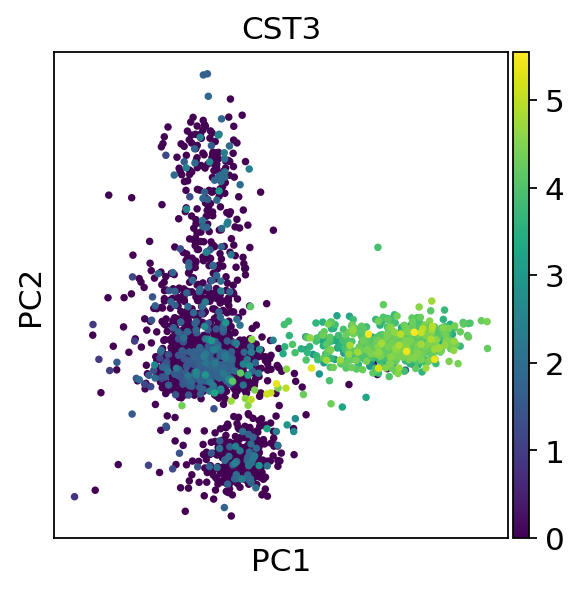

In [34]:
sc.pl.pca(adata, color='CST3')

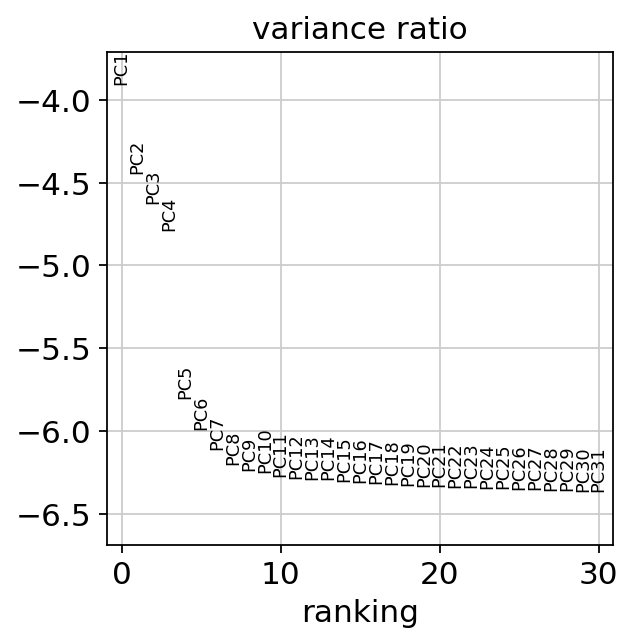

In [35]:
sc.pl.pca_variance_ratio(adata, log=True)

In [36]:
adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [37]:
adata.obsm['X_pca'].shape

(2638, 50)

In [38]:
adata.var.columns

Index(['gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts',
       'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means',
       'dispersions', 'dispersions_norm', 'mean', 'std'],
      dtype='object')

In [39]:
# compute neighbourhood graph 
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:03)


n_neighbors : The size of local neighborhood (in terms of number of neighboring data points) used for manifold approximation. Larger values result in more global views of the manifold, while smaller values result in more local data being preserved. In general values should be in the range 2 to 100. If knn is True, number of nearest neighbors to be searched. If knn is False, a Gaussian kernel width is set to the distance of the n_neighbors neighbor.

In [40]:
print(adata.obsp['connectivities'].shape, adata.obsp['distances'].shape)

(2638, 2638) (2638, 2638)


In [41]:
(adata.obsp['connectivities'] > 0.).sum(axis=1).max()

173

(array([2.343e+03, 1.900e+02, 6.000e+01, 2.500e+01, 9.000e+00, 5.000e+00,
        1.000e+00, 1.000e+00, 2.000e+00, 2.000e+00]),
 array([  9. ,  25.4,  41.8,  58.2,  74.6,  91. , 107.4, 123.8, 140.2,
        156.6, 173. ]),
 <BarContainer object of 10 artists>)

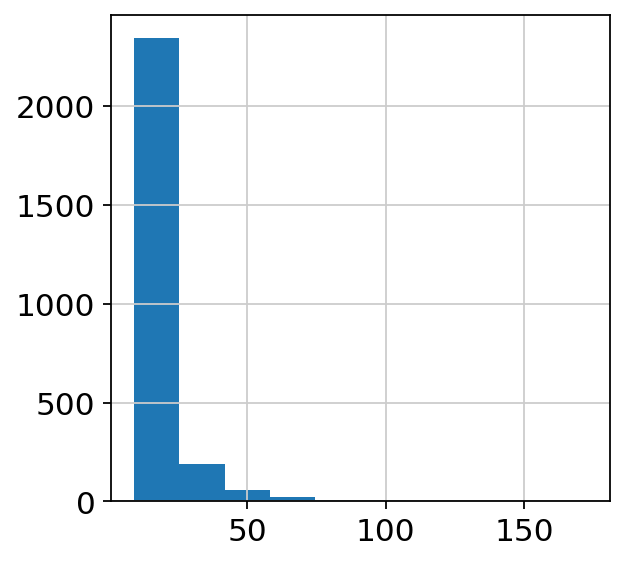

In [42]:
plt.hist(np.asarray((adata.obsp['connectivities'] > 0.).sum(axis=1)).flatten())

(array([1174., 1156.,  239.,   46.,   12.,    6.,    0.,    2.,    0.,
           3.]),
 array([0.02082998, 0.03266794, 0.0445059 , 0.05634386, 0.06818182,
        0.08001978, 0.09185774, 0.1036957 , 0.11553366, 0.12737162,
        0.13920958]),
 <BarContainer object of 10 artists>)

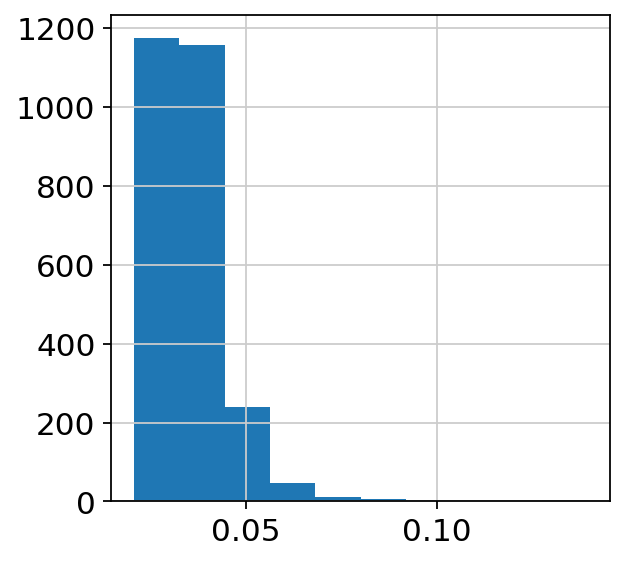

In [43]:
plt.hist(np.asarray(adata.obsp['distances'].mean(axis=1)).flatten())

In [44]:
adata.X.shape

(2638, 1838)

In [45]:
# embed graph in two dimensions
# https://scanpy.readthedocs.io/en/latest/generated/scanpy.tl.umap.html#scanpy-tl-umap
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:05)


In [46]:
adata.obsm['X_umap'].shape

(2638, 2)

In [47]:
adata.obsm['X_umap']

array([[10.467079 ,  5.430643 ],
       [ 5.6091604, 12.295992 ],
       [ 7.4103274,  6.5344996],
       ...,
       [ 4.029182 , 11.759854 ],
       [ 3.6731677, 12.958695 ],
       [ 7.9061794,  5.281012 ]], dtype=float32)

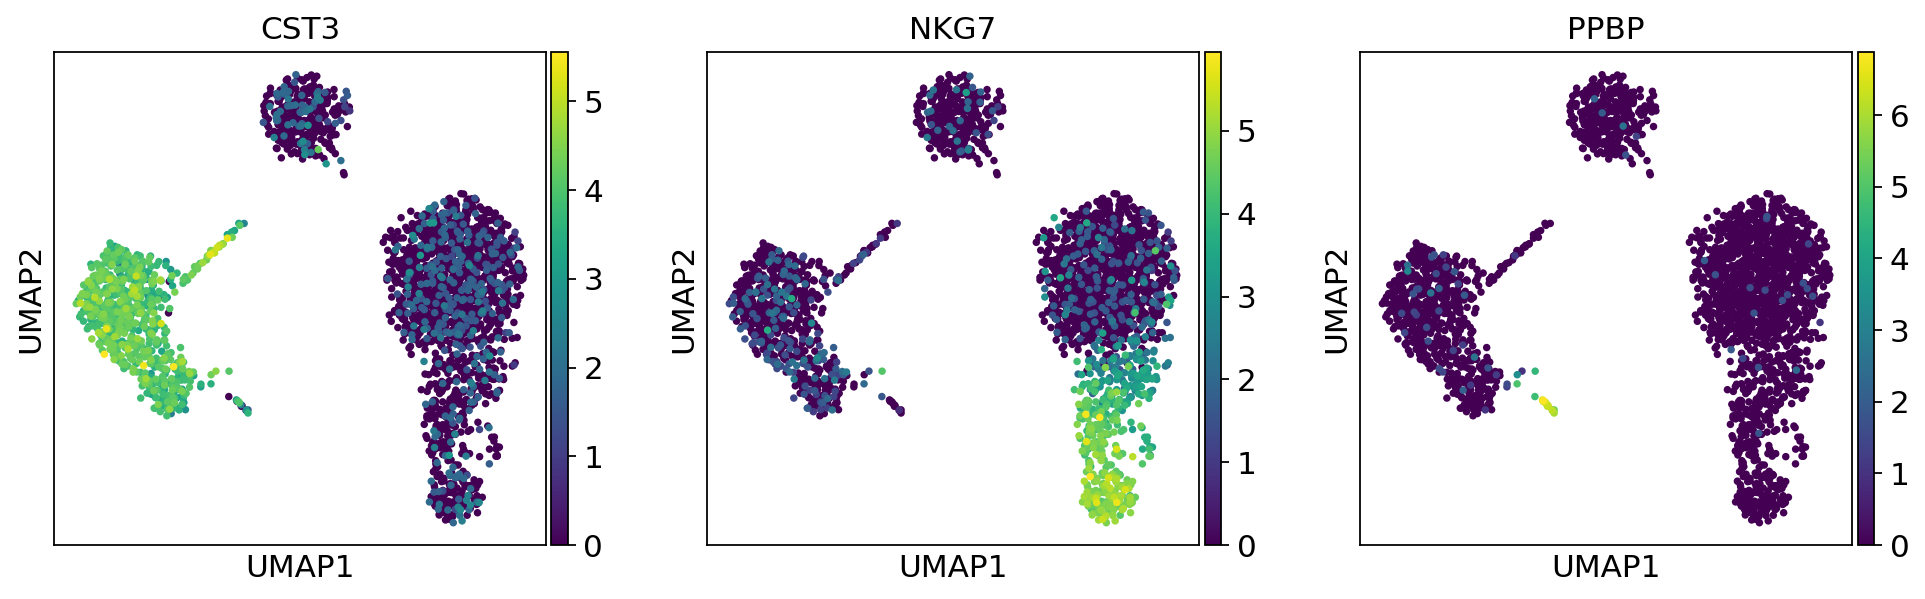

In [48]:
sc.pl.umap(adata, color=['CST3', 'NKG7', 'PPBP'])

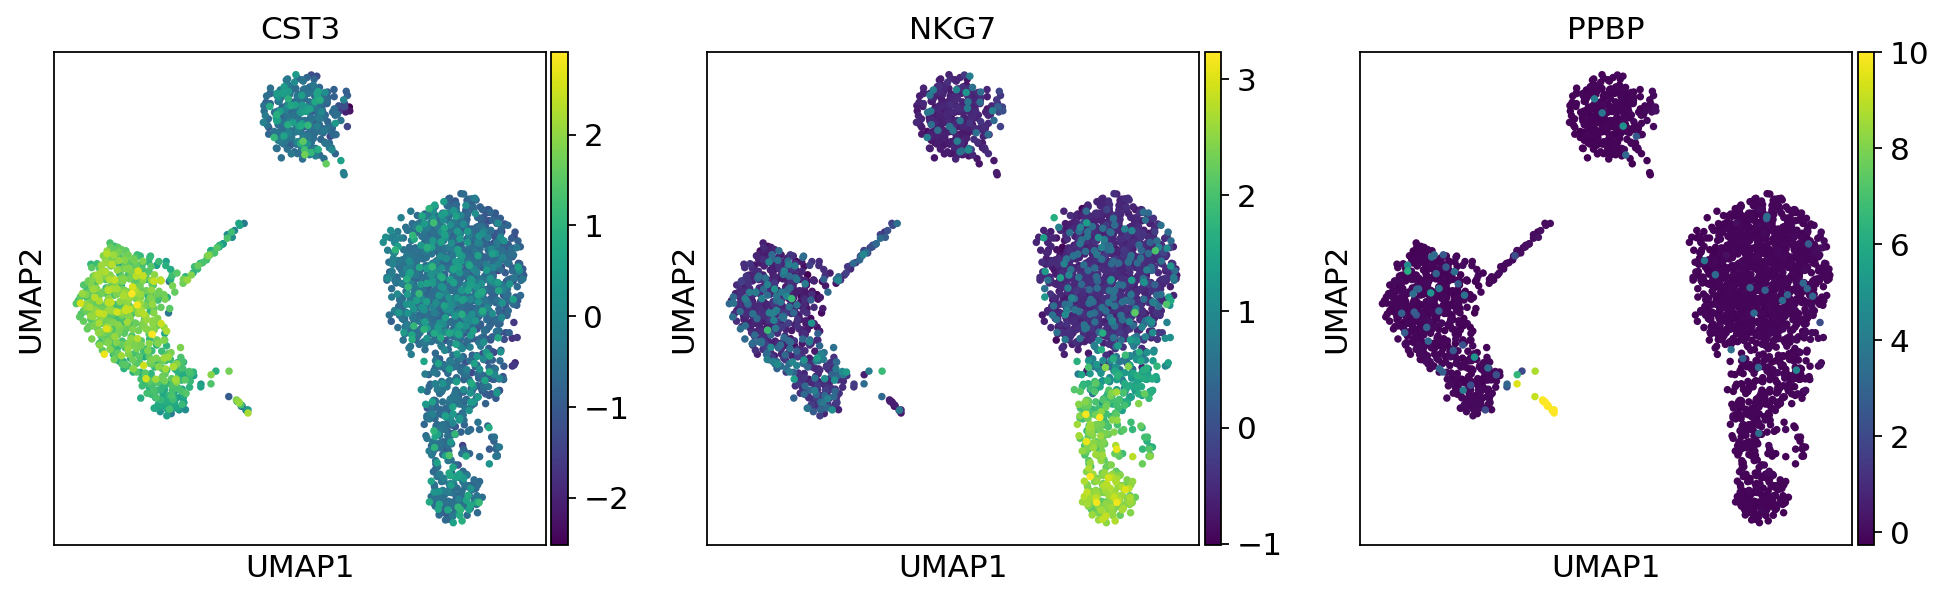

In [49]:
sc.pl.umap(adata, color=['CST3', 'NKG7', 'PPBP'], use_raw=False)

In [50]:
# Leiden clustering 
sc.tl.leiden(adata)

running Leiden clustering
    finished: found 9 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


In [51]:
adata.obs.head().loc[:, ['leiden']]

,leiden
AAACATACAACCAC-1,4
AAACATTGAGCTAC-1,3
AAACATTGATCAGC-1,1
AAACCGTGCTTCCG-1,5
AAACCGTGTATGCG-1,6


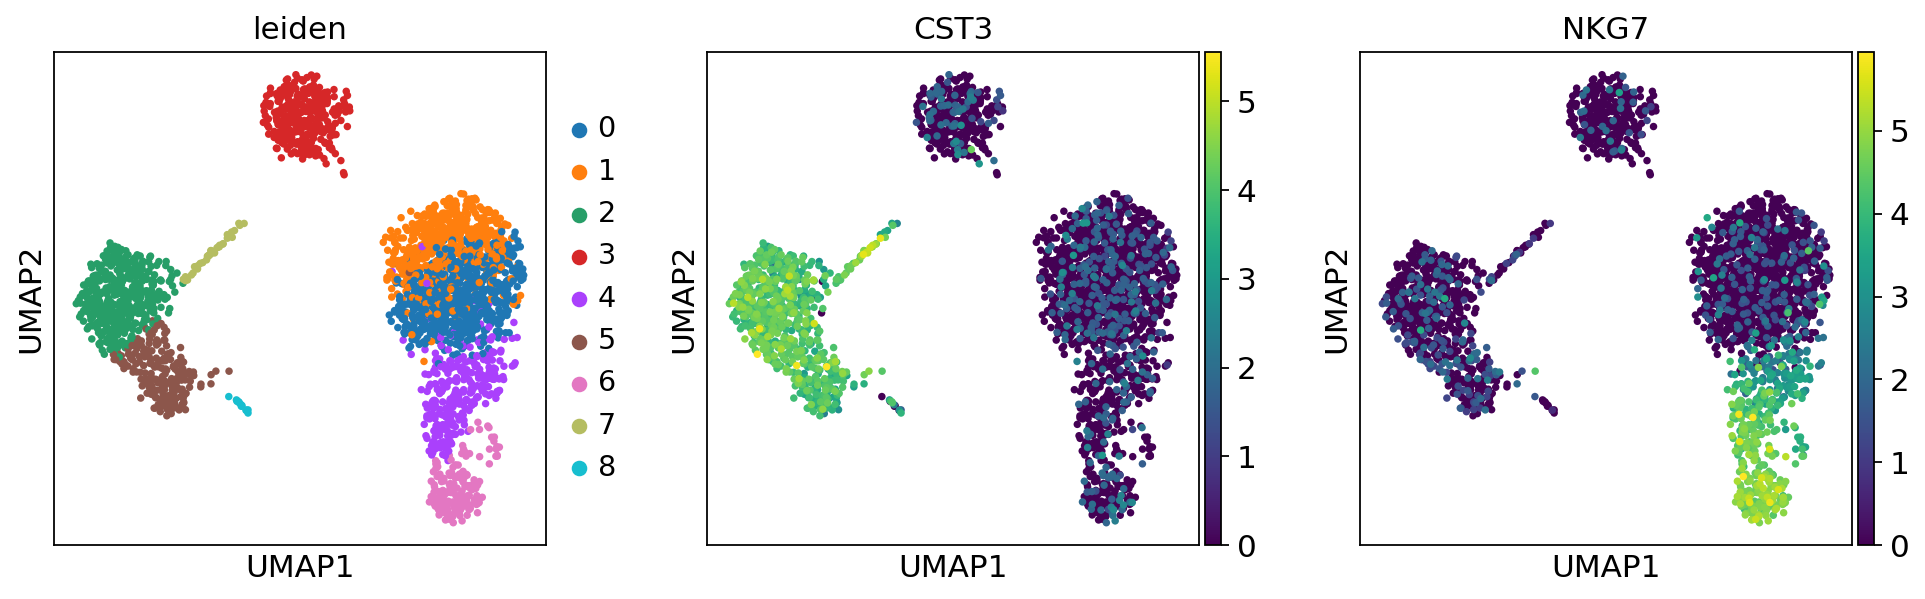

In [52]:
sc.pl.umap(adata, color=['leiden', 'CST3', 'NKG7'])

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


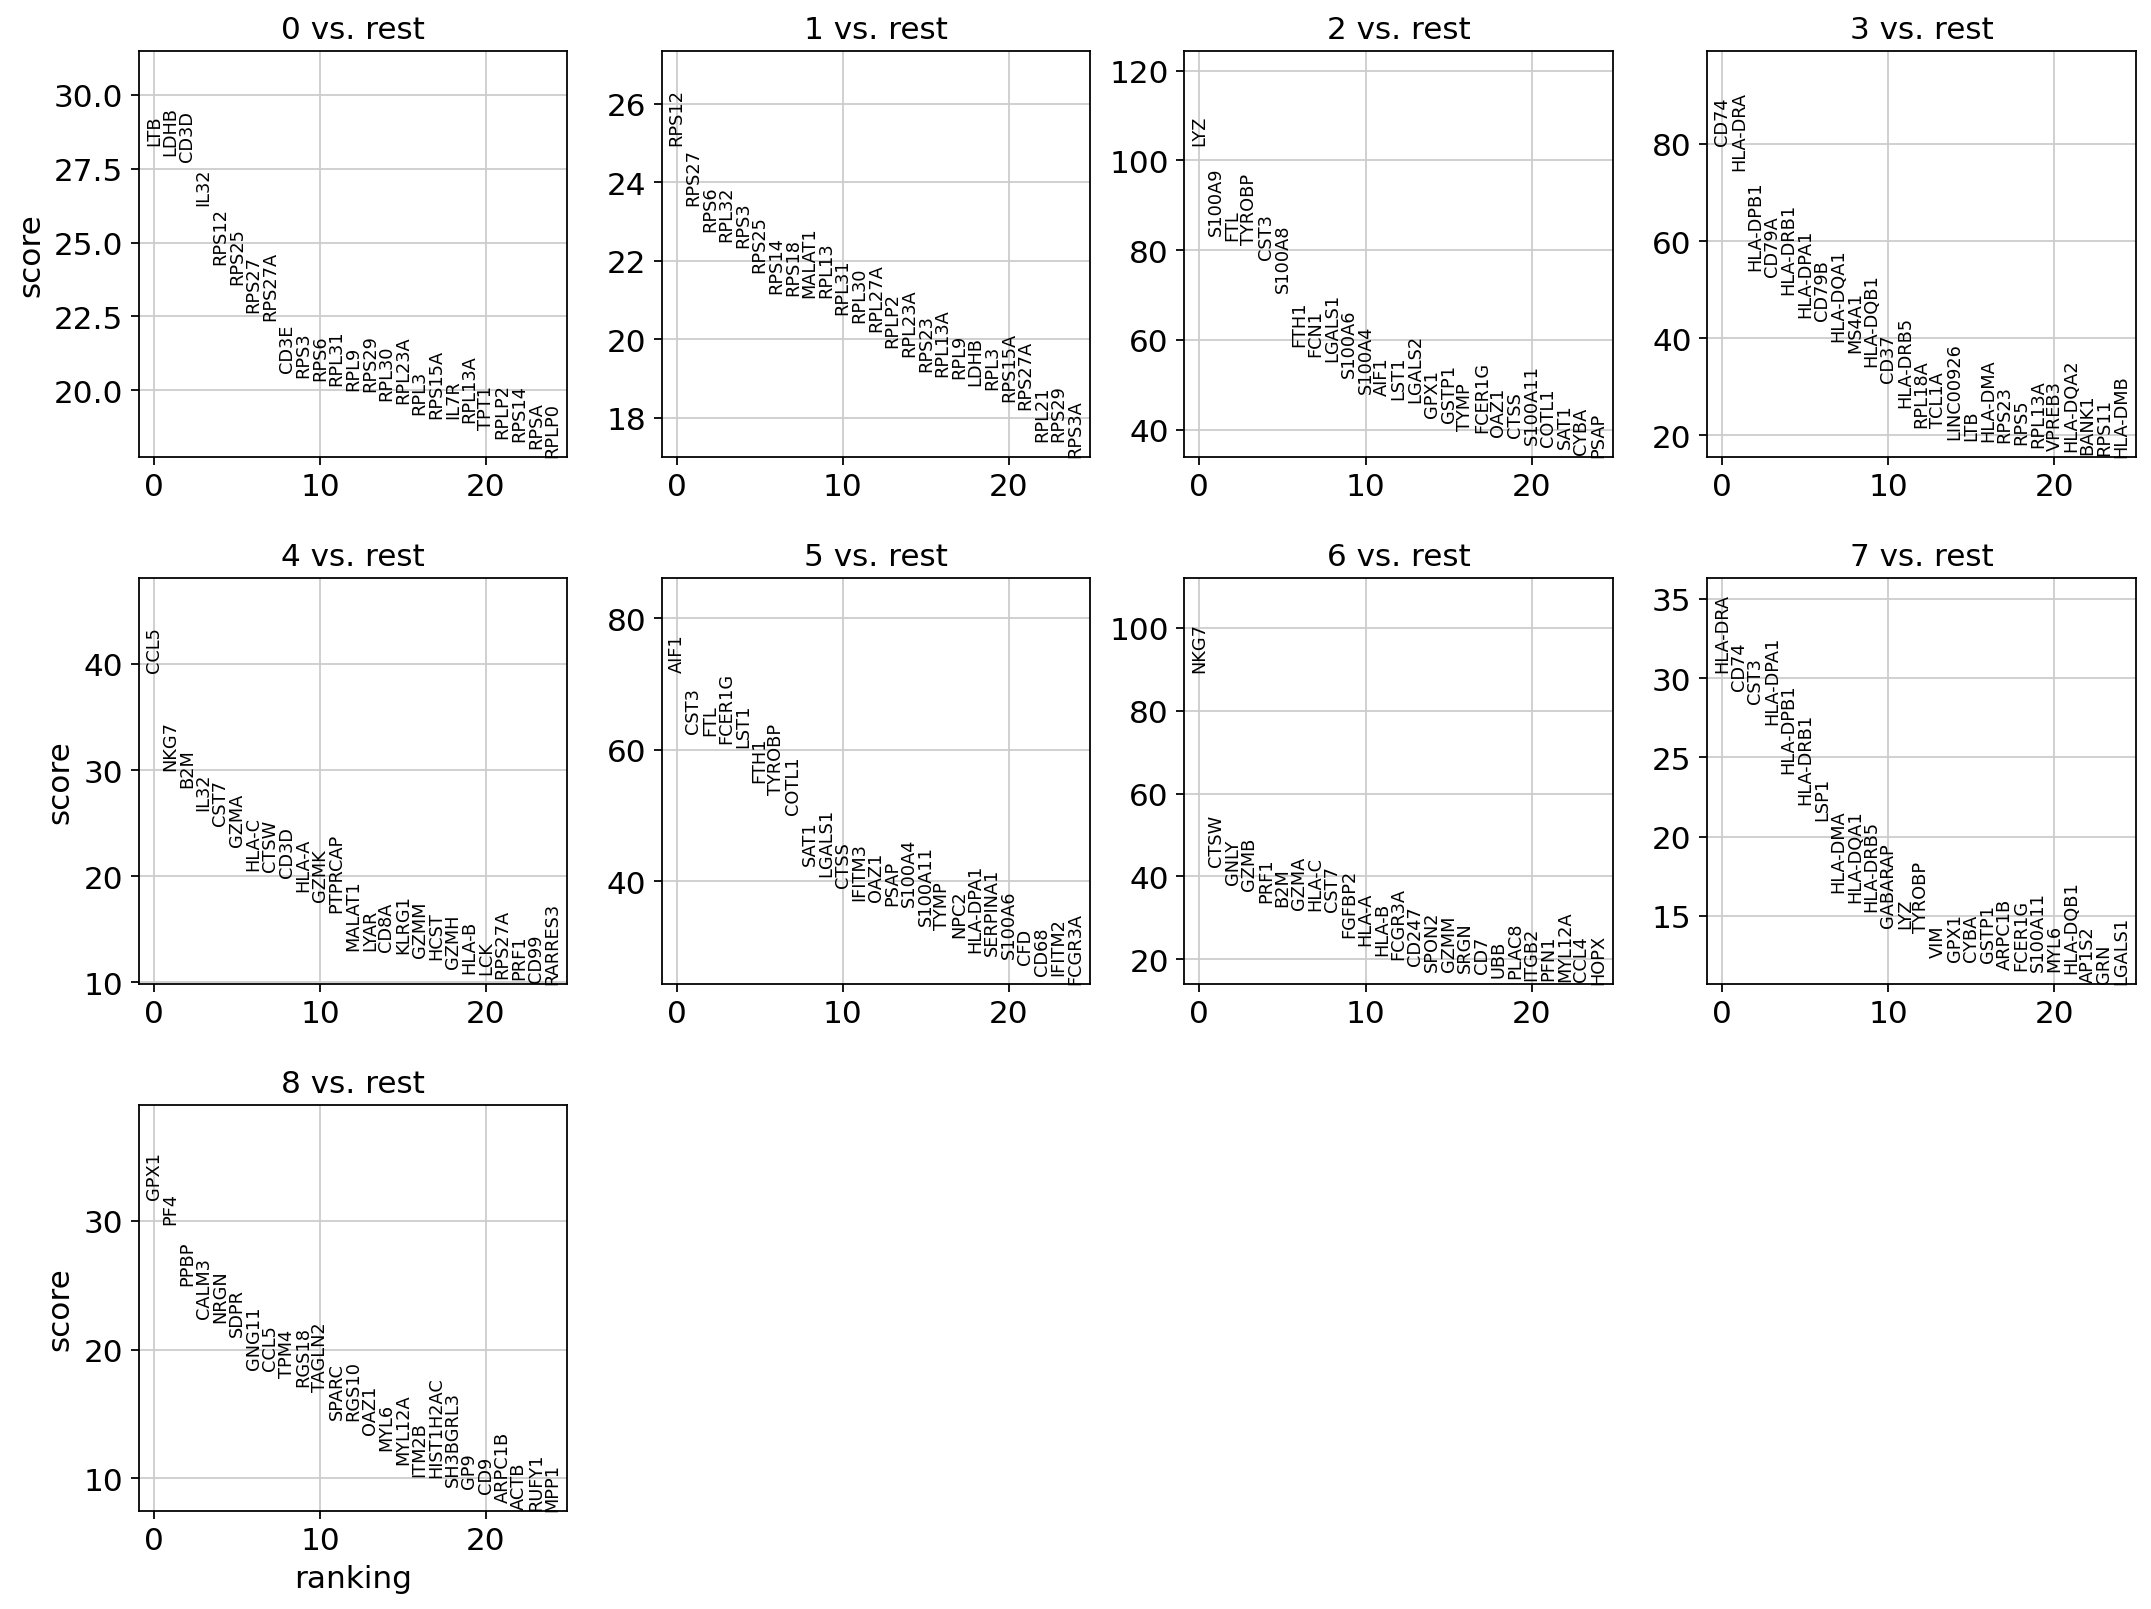

In [53]:
# find marker genes
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [54]:
adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:02)


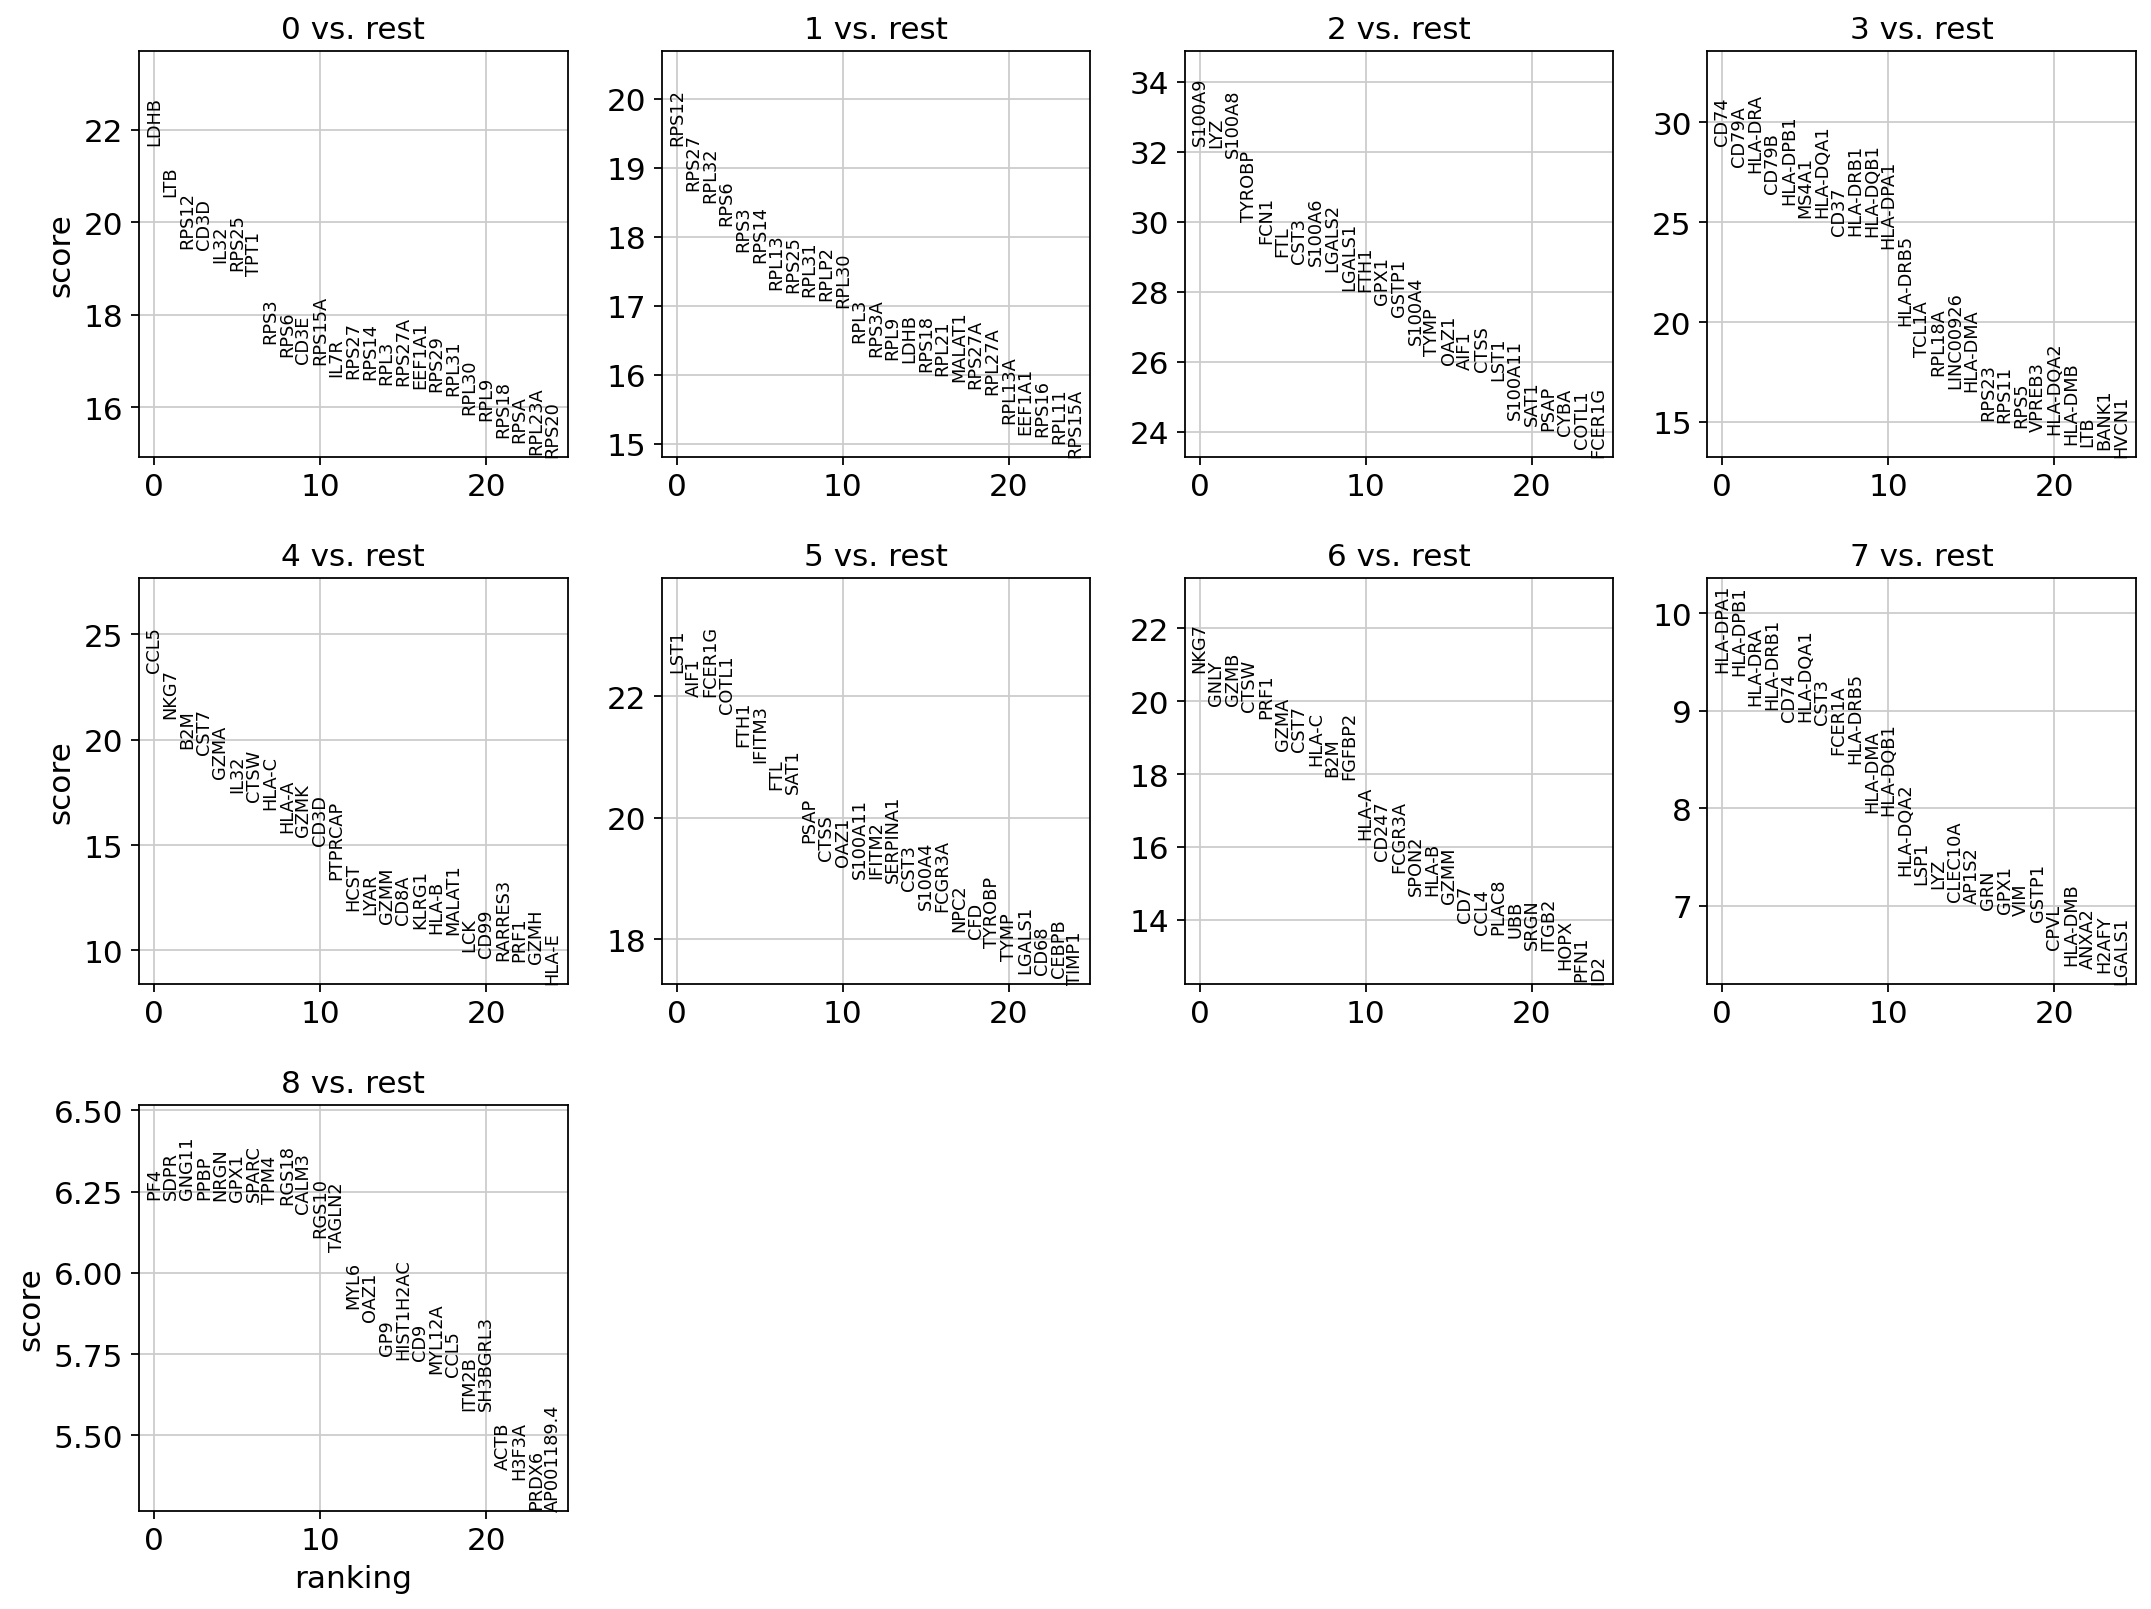

In [55]:
# rank genes using wilcoxon method - similar result
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [56]:
adata.uns['rank_genes_groups']['names']

rec.array([('LDHB', 'RPS12', 'S100A9', 'CD74', 'CCL5', 'LST1', 'NKG7', 'HLA-DPA1', 'PF4'),
           ('LTB', 'RPS27', 'LYZ', 'CD79A', 'NKG7', 'AIF1', 'GNLY', 'HLA-DPB1', 'SDPR'),
           ('RPS12', 'RPL32', 'S100A8', 'HLA-DRA', 'B2M', 'FCER1G', 'GZMB', 'HLA-DRA', 'GNG11'),
           ...,
           ('HLA-DRB1', 'HLA-DRA', 'RPS27', 'S100A6', 'FTH1', 'RPL13A', 'RPL28', 'RPL21', 'RPL11'),
           ('HLA-DRA', 'CD74', 'RPS27A', 'TMSB4X', 'RPS11', 'RPL13', 'RPL18A', 'RPS27', 'MALAT1'),
           ('CD74', 'CYBA', 'MALAT1', 'S100A4', 'TMSB10', 'RPL3', 'RPL32', 'MALAT1', 'RPL10')],
          dtype=[('0', 'O'), ('1', 'O'), ('2', 'O'), ('3', 'O'), ('4', 'O'), ('5', 'O'), ('6', 'O'), ('7', 'O'), ('8', 'O')])

In [57]:
marker_genes = ['IL7R', 'CD79A', 'MS4A1', 'CD8A', 'CD8B', 'LYZ', 'CD14',
                'LGALS3', 'S100A8', 'GNLY', 'NKG7', 'KLRB1',  
                'FCGR3A', 'MS4A7', 'FCER1A', 'CST3', 'PPBP']

In [58]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)

,0,1,2,3,4,5,6,7,8
0,LDHB,RPS12,S100A9,CD74,CCL5,LST1,NKG7,HLA-DPA1,PF4
1,LTB,RPS27,LYZ,CD79A,NKG7,AIF1,GNLY,HLA-DPB1,SDPR
2,RPS12,RPL32,S100A8,HLA-DRA,B2M,FCER1G,GZMB,HLA-DRA,GNG11
3,CD3D,RPS6,TYROBP,CD79B,CST7,COTL1,CTSW,HLA-DRB1,PPBP
4,IL32,RPS3,FCN1,HLA-DPB1,GZMA,FTH1,PRF1,CD74,NRGN


In [59]:
adata.uns['log1p']['base'] = None
sc.tl.rank_genes_groups(adata, 'leiden', groups=['0'], reference='1', method='wilcoxon')

new_cluster_names = [
    'CD4 T', 'CD14 Monocytes',
    'B', 'CD8 T', 
    'NK', 'FCGR3A Monocytes',
    'Dendritic', 'Megakaryocytes']
adata.rename_categories('leiden', new_cluster_names)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


/home/hbl/.local/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.rename_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)


ValueError: new categories need to have the same number of items as the old categories!

In [60]:
# try SVM 

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

n_train = 1800
x_train, x_test = adata.X[:n_train, :], adata.X[n_train:, :]
y_train, y_test = adata.obs.iloc[:n_train].leiden, adata.obs.iloc[n_train:].leiden

process_y = lambda x: np.array(x.values).astype(int)
y_train = process_y(y_train)
y_test = process_y(y_test)

clf = SVC(kernel='linear')
clf.fit(x_train,y_train)
y_pred = clf.predict(x_test)
print(accuracy_score(y_test,y_pred))

0.8138424821002387


GNNS: 
- what to use as node features? 
- what to use as edge features? 
- what to use as adjacency matrix? 
- how to split into test/train/validation?
- inductive?
- what is the target for cell classification? 

In [61]:
# try simple MLP and GNN model 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch_geometric
from torch_scatter import scatter_mean, scatter_max, scatter_sum
from torch_geometric.utils import to_dense_adj
from torch.nn import Embedding

In [62]:
class SimpleMLP(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim):
        super(SimpleMLP, self).__init__()
        self.layer_1 = nn.Linear(input_dim, hidden_dim)
        self.layer_2 = nn.Linear(hidden_dim, output_dim)
        self.seq = nn.Sequential(
            self.layer_1, nn.ReLU(), self.layer_2
        )

    def forward(self, x):
        x = self.seq(x)
        # y_hat = F.log_softmax(x, dim=1)
        y_hat = F.softmax(x, dim=1)
        return y_hat

In [238]:
def leiden2target_onehot(adata: sc.AnnData): 
    return F.one_hot(torch.tensor(adata.obs.leiden.values.astype(int)))

In [63]:
NUM_EPOCHS = 100
LR = 0.001 
n_train = 1800

# y_raw = torch.tensor(adata.obs.leiden.values.astype(int))
x = torch.tensor(adata.X)
y = leiden2target_onehot(adata)

x_train = x[:n_train, :]
y_train = y[:n_train]

x_test = torch.tensor(adata.X[n_train:, :])
y_test = y[n_train:]

input_dim = adata.X.shape[1]
output_dim = len(adata.obs['leiden'].dtype.categories)

accuracy: tensor(78.8783)


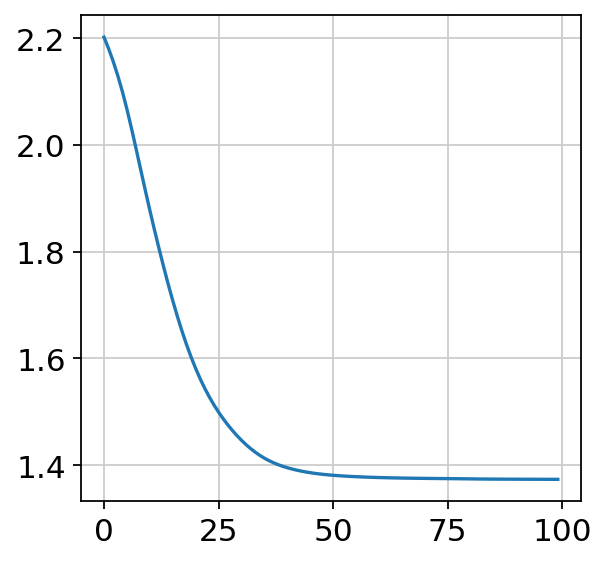

In [123]:
model = SimpleMLP(adata.X.shape[1], len(adata.obs['leiden'].dtype.categories), 64)

optimiser = optim.Adam(model.parameters(), lr=LR)

losses = []
for epoch in range(NUM_EPOCHS):
    model.train()
    optimiser.zero_grad()
    y_hat = model(x_train)
    loss = F.cross_entropy(y_hat, y_train)
    loss.backward()
    optimiser.step()
    losses.append(loss.item())

model.eval()
y_hat = model(x_test)
y_hat = y_hat.data.max(1)[1]
num_correct = y_hat.eq(y_raw[n_train:].data).sum()
num_total = len(y_hat)
accuracy = 100.0 * (num_correct/num_total)
print('accuracy:', accuracy)
plt.plot(losses)

In [65]:
class GCNLayer(nn.Module):
    """GCN layer, but with a larger receptive field

    Args:
        input_dim (int): Dimensionality of the input feature vectors
        output_dim (int): Dimensionality of the output softmax distribution
        A (torch.Tensor): 2-D adjacency matrix
    """
    def __init__(self, input_dim, output_dim, A, k=1):
        super(GCNLayer, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.A = A
        self.k = k 

        # Compute symmetric norm
        Atilde = torch.matrix_power(A + torch.eye(A.shape[0]), k)
        Dtilde_invsqrt = torch.diag(Atilde.sum(0).pow(-1/2))
        self.Anorm = (torch.matmul(torch.matmul(Dtilde_invsqrt, Atilde), Dtilde_invsqrt))
        # + Simple linear transformation and non-linear activation
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        x = self.linear(torch.matmul(self.Anorm, x))
        x = F.softmax(x, dim=1)
        return x

class SimpleGNN(nn.Module):
    """Simple GNN model using the GCNLayer implemented by students

    Args:
        input_dim (int): Dimensionality of the input feature vectors
        output_dim (int): Dimensionality of the output softmax distribution
        A (torch.Tensor): 2-D adjacency matrix
    """
    def __init__(self, input_dim, output_dim, A, gcnlayer = GCNLayer, **kwargs):
        super(SimpleGNN, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.A = A
        self.gcn_layer = gcnlayer(input_dim, output_dim, A, **kwargs)

    def forward(self, x):
        x = self.gcn_layer(x)
        # y_hat = F.log_softmax(x, dim=1) <- old version
        # y_hat = x
        y_hat = F.softmax(x, dim=1)
        return y_hat

accuracy: tensor(92.6014)


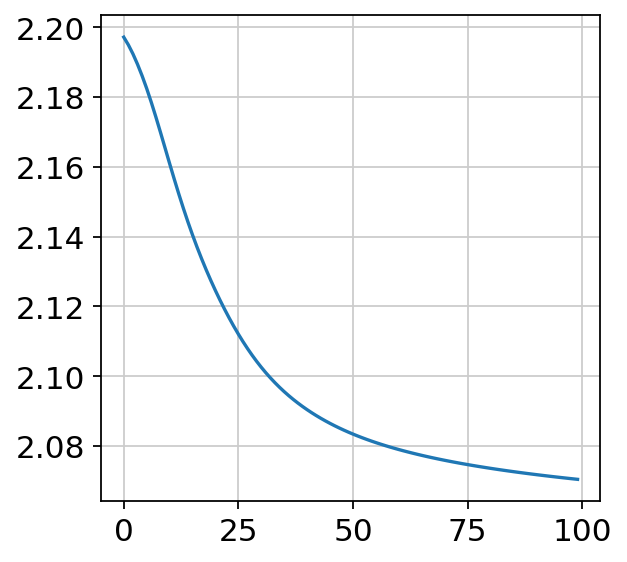

In [125]:
A = torch.tensor((adata.obsp['connectivities'].A > 0.)).float()
model = SimpleGNN(input_dim, output_dim, A, k=1)

optimiser = optim.Adam(model.parameters(), lr=LR)

losses = []
for epoch in range(NUM_EPOCHS):
    model.train()
    optimiser.zero_grad()
    y_hat = model(x)[:n_train]
    loss = F.cross_entropy(y_hat, y[:n_train])
    loss.backward()
    optimiser.step()
    losses.append(loss.item())

model.eval()
y_hat = model(x)[n_train:]
y_hat = y_hat.data.max(1)[1]
num_correct = y_hat.eq(y_raw[n_train:].data).sum()
num_total = len(y_hat)
accuracy = 100.0 * (num_correct/num_total)
print('accuracy:', accuracy)
plt.plot(losses)

accuracy: tensor(94.0334)


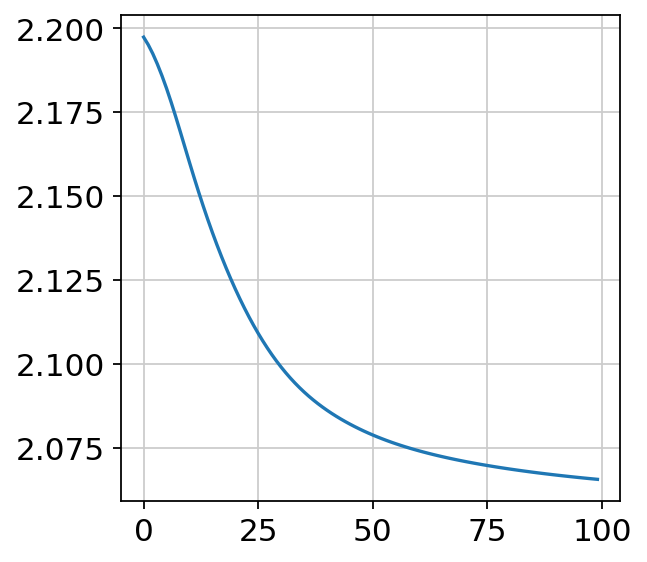

In [210]:
Afloat = torch.tensor(adata.obsp['connectivities'].A).float()

model = SimpleGNN(input_dim, output_dim, Afloat, k=1)

optimiser = optim.Adam(model.parameters(), lr=LR)

losses = []
for epoch in range(NUM_EPOCHS):
    model.train()
    optimiser.zero_grad()
    y_hat = model(x)[:n_train]
    loss = F.cross_entropy(y_hat, y[:n_train])
    loss.backward()
    optimiser.step()
    losses.append(loss.item())

model.eval()
y_hat = model(x)[n_train:]
y_hat = y_hat.data.max(1)[1]
num_correct = y_hat.eq(y_raw[n_train:].data).sum()
num_total = len(y_hat)
accuracy = 100.0 * (num_correct/num_total)
print('accuracy:', accuracy)
plt.plot(losses)

In [213]:
adata.obsp['distances']

<2638x2638 sparse matrix of type '<class 'numpy.float64'>'
	with 23742 stored elements in Compressed Sparse Row format>

In [68]:
def connectivities2sparse(adata: sc.AnnData, binary=True):
    coo = scipy.sparse.coo_matrix(adata.obsp['connectivities'])
    if binary:
        values = np.ones_like(coo.data)
    else: 
        values = coo.data 
    indices = np.vstack((coo.row, coo.col))
    i = torch.LongTensor(indices)
    v = torch.FloatTensor(values)
    shape = coo.shape
    if binary:
        return torch.sparse.LongTensor(i, v, torch.Size(shape))
    return torch.sparse.FloatTensor(i, v, torch.Size(shape))

In [ ]:
def edge_index_from_sparse(A_sparse):
    return A_sparse.coalesce().indices()

In [205]:
class Graph(object):
    def __init__(self, edge_index, x, y):
        """ Graph structure 
            for a mini-batch it will store a big (sparse) graph 
            representing the entire batch
        Args:
            x: node features  [num_nodes x num_feats]
            y: graph labels   [num_graphs]
            edge_index: list of edges [2 x num_edges]
        """
        self.edge_index = edge_index
        self.x = x.to(torch.float32)
        self.y = y
        self.num_nodes = self.x.shape[0]

    #ignore this for now, it will be useful for batching
    def set_batch(self, batch):
        """ list of ints that maps each node to the graph it belongs to
            e.g. for batch = [0,0,0,1,1,1,1]: the first 3 nodes belong to graph_0 while
            the last 4 belong to graph_1
        """
        self.batch = batch

    # this function return a sparse tensor
    def get_adjacency_matrix(self):
        """ from the list of edges create 
        a num_nodes x num_nodes sparse adjacency matrix
        """
        return torch.sparse.LongTensor(self.edge_index, 
                              # we work with a binary adj containing 1 if an edge exist
                              torch.ones((self.edge_index.shape[1])), 
                              torch.Size((self.num_nodes, self.num_nodes))
                              )

class GINLayer(nn.Module):
    """A single GIN layer, implementing MLP(AX + (1+eps)X)"""
    def __init__(self, in_feats: int, out_feats: int, hidden_dim: int, eps: float=0.0):
        super(GINLayer, self).__init__()
        self.in_feats = in_feats
        self.out_feats = out_feats
        # ============ YOUR CODE HERE =============
        # epsilon should be a learnable parameter
        self.eps = nn.Parameter(torch.Tensor([eps]))
        # =========================================
        self.linear1 = nn.Linear(self.in_feats, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, self.out_feats)

    def forward(self, x, adj_sparse): 
        # ============ YOUR CODE HERE =============
        # aggregate the neighbours as in GIN: (AX + (1+eps)X)
        x = torch.sparse.mm(adj_sparse, x) + (1 + self.eps) * x
        
        # project the features (MLP_k)
        x = self.linear1(x)
        x = self.linear2(x)
        # =========================================
        return x

class GIN(nn.Module):
    """ 
    A Graph Neural Network containing GIN layers 
    as in https://arxiv.org/abs/1810.00826 
    The readout function used to obtain graph-lvl representations
    aggregate pred from multiple layers (as in JK-Net)

    Args:
    input_dim (int): Dimensionality of the input feature vectors
    output_dim (int): Dimensionality of the output softmax distribution
    num_layers (int): Number of layers
    """
    def __init__(self, input_dim, output_dim, hidden_dim, num_layers=2, eps=0.0, \
                 molecular=True, concat=True):
        super(GIN, self).__init__()
        self.num_layers = num_layers 
        self.molecular = molecular
        # nodes in ZINC dataset are characterised by one integer (atom category)
        # we will create embeddings from the categorical features using nn.Embedding
        if self.molecular:
            self.embed_x = Embedding(28, hidden_dim)
        else:
            self.embed_x = nn.Linear(input_dim, hidden_dim)
            # self.embed_x = nn.Linear(input_dim, input_dim)

        # ============ YOUR CODE HERE =============
        # should be the same as before (an nn.ModuleList of GINLayers)
        self.layers = [GINLayer(hidden_dim, hidden_dim, hidden_dim, eps) for _ in range(num_layers)]
        self.layers = nn.ModuleList(self.layers)

        # layer to compute prediction from the concatenated intermediate representations
        self.concat_linear = nn.Linear(hidden_dim * num_layers, output_dim)
        self.concat = concat

        # also try pushing intermediate layers through their own linear layers 
        # and sum up/average, maybe use ReLU or other nonlinear as well 
        # could also use dropout, as in the paper
        self.interim_layers = [nn.Linear(hidden_dim, output_dim) for _ in range(num_layers)]
        self.interim_layers = nn.ModuleList(self.interim_layers)

        self.pred = SimpleMLP(hidden_dim, output_dim, hidden_dim)
        # could try inputting all intermediate layers, num_layers * hidden_dim -> output_dim
        total_dim = num_layers*hidden_dim
        # self.pred = SimpleMLP(total_dim, output_dim, total_dim)
        # self.pred = nn.Sequential(
        #     SimpleMLP(total_dim, total_dim, total_dim), 
        #     SimpleMLP(total_dim, total_dim, total_dim),
        #     SimpleMLP(total_dim, total_dim, hidden_dim),
        # )
        # =========================================

    def forward(self, graph):
        adj_sparse = graph.get_adjacency_matrix()
        if self.molecular:
            x = self.embed_x(graph.x.long()).squeeze(1)
        else:
            x = self.embed_x(graph.x)

        # ============ YOUR CODE HERE ============= 
        # perform the forward pass with the new readout function  
        hk = []
        for i in range(self.num_layers):
            x = self.layers[i](x, adj_sparse)
            x = F.relu(x)
            hk.append(x)

        # y_hat = self.pred(x)
        # return y_hat, x

        # x_concat = torch.cat(hk, axis=1)
        # y_hat = self.pred(x_concat)
        # return y_hat, x

        y_hat = torch.stack([self.pred(h) for h in hk])
        # print(y_hat.mean(axis=0).shape)
        return y_hat.mean(axis=0), x

        if self.concat: 
            x_concat = [scatter_sum(h, graph.batch, 0) for h in hk]
            y_hat = self.concat_linear(x_concat)
        else: 
            y_hat = 0
            for k,h in enumerate(hk):
                pooled_h = scatter_sum(h, graph.batch, 0)
                y_hat += self.interim_layers[k](pooled_h)
        
        # =========================================

        y_hat = y_hat.squeeze(-1)
        # return also the final node embeddings (for visualisations)
        return y_hat, x

In [203]:
A_sparse = connectivities2sparse(adata)
edge_index = edge_index_from_sparse(A_sparse)
A_sparse

tensor(indices=tensor([[   0,    0,    0,  ..., 2637, 2637, 2637],
                       [  60,  108,  474,  ..., 2077, 2572, 2574]]),
       values=tensor([1., 1., 1.,  ..., 1., 1., 1.]),
       size=(2638, 2638), nnz=41952, layout=torch.sparse_coo)

In [215]:
graph = Graph(edge_index, x, y)
graph.set_batch(torch.zeros((x.shape[0]), dtype=torch.int64))

model_gin = GIN(input_dim=input_dim, molecular=False, output_dim=output_dim, hidden_dim=64, num_layers=4, eps=0.1, concat=False)
y_hat, _ = model_gin(graph)

# train_loss = F.mse_loss(y_hat, graph.y)
train_loss = F.cross_entropy(y_hat, graph.y)
print('training loss:', train_loss)

num_correct = y_hat.max(axis=1).indices.eq(graph.y.max(axis=1).indices).sum()
num_total = y_hat.shape[0]
accuracy = 100.0 * (num_correct/num_total)
print('accuracy:', accuracy)

training loss: tensor(2.2045, grad_fn=<DivBackward1>)
accuracy: tensor(13.0781)


(array([   4.,    0., 2283.,    0.,   11.,  104.,    0.,    0.,  127.,
         109.]),
 array([1. , 1.7, 2.4, 3.1, 3.8, 4.5, 5.2, 5.9, 6.6, 7.3, 8. ]),
 <BarContainer object of 10 artists>)

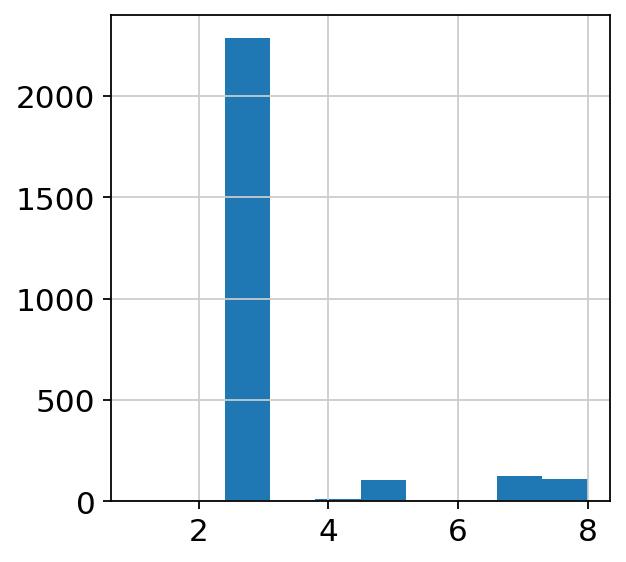

In [216]:
plt.hist(y_hat.max(axis=1).indices.tolist())

loss: tensor(1.7681)
accuracy: tensor(60.3819)


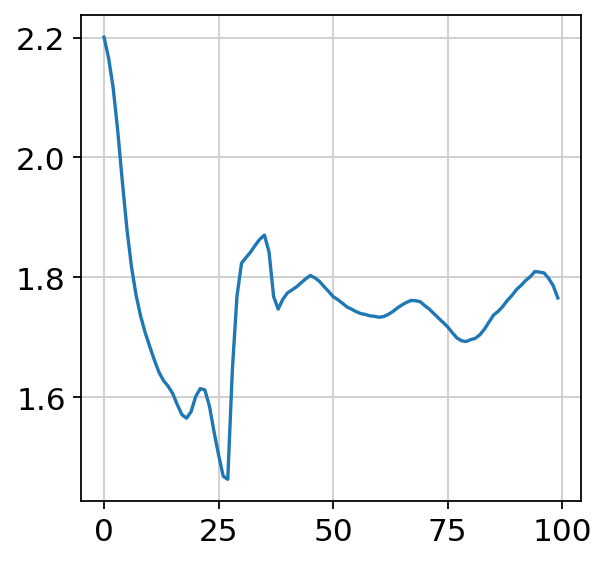

In [219]:
graph = Graph(edge_index, x, y)
# full batch training for now 
graph.set_batch(torch.zeros((x.shape[0]), dtype=torch.int64))

model = GIN(input_dim=input_dim, output_dim=output_dim, molecular=False, hidden_dim=64, num_layers=1, eps=0.1, concat=False)
optimiser = optim.Adam(model.parameters(), lr=LR)
# loss_fct = F.mse_loss
loss_fct = F.cross_entropy

losses = []
for epoch in range(NUM_EPOCHS):
    model.train()
    # TODO minibatch data
    # num_iter = int(len(dataset)/BATCH_SIZE)
    # for i in range(num_iter):
    #     batch_list = dataset[i*BATCH_SIZE:(i+1)*BATCH_SIZE]
    #     batch = create_mini_batch(batch_list)
    #     optimiser.zero_grad()
    #     y_hat, _ = model(batch)
    #     loss = loss_fct(y_hat, batch.y)
    #     metric = metric_fct(y_hat, batch.y)
    #     loss.backward()
    #     optimiser.step() 
    #     if (i+1) % print_every == 0:
    #       print(f"Epoch {epoch} Iter {i}/{num_iter}",
    #                 f"Loss train {loss.data}; Metric train {metric.data}")
    y_hat, _ = model(graph)
    train_loss = loss_fct(y_hat[:n_train], graph.y[:n_train])
    train_loss.backward()
    optimiser.step() 

    losses.append(train_loss.item())

    # train_loss, train_metric = train(train_dataset, model, optimiser, epoch, 
    #                                 loss_fct, metric_fct, print_every)
                                    
    # val_loss, val_metric = evaluate(val_dataset, model, loss_fct, metric_fct)
    # print(f"[Epoch {epoch+1}]",
    #             f"train loss: {train_loss:.3f} val loss: {val_loss:.3f}",
    #             f"train metric: {train_metric:.3f} val metric: {val_metric:.3f}"
    #         )
    # store the loss and the computed metric for the final plot
    # epoch_stats = {'train_loss': train_loss.clone().detach(), 'val_loss': val_loss, 
    #                 'train_metric': train_metric.clone().detach(), 'val_metric': val_metric, 
    #                 'epoch':epoch+1}
    # training_stats = update_stats(training_stats, epoch_stats)
plt.plot(losses)

model.eval()
with torch.no_grad():
    y_hat, _ = model(graph)
    y_hat = y_hat[n_train:]
    num_correct = y_hat.max(axis=1).indices.eq(graph.y[n_train:].max(axis=1).indices).sum()
    num_total = y_hat.shape[0]
    accuracy = 100.0 * (num_correct/num_total)
    print('loss:', loss_fct(y_hat, graph.y[n_train:]))
    print('accuracy:', accuracy)

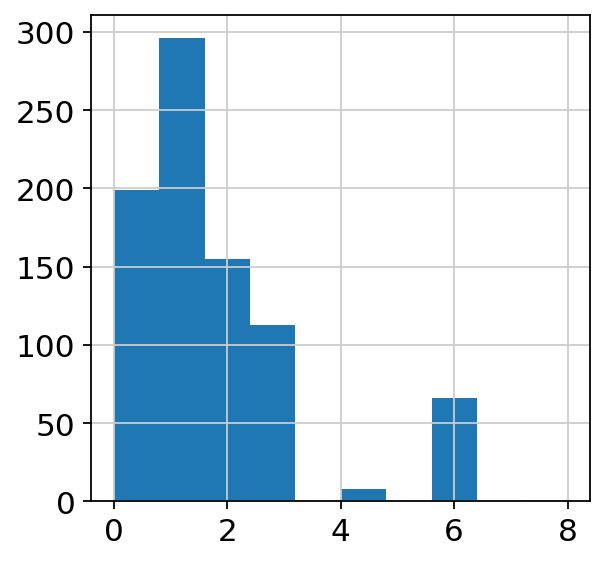

In [220]:
plt.hist(y_hat.max(axis=1).indices.tolist())
plt.show()

(array([664., 485., 431., 341.,   0., 299., 206., 163.,  36.,  13.]),
 array([0. , 0.8, 1.6, 2.4, 3.2, 4. , 4.8, 5.6, 6.4, 7.2, 8. ]),
 <BarContainer object of 10 artists>)

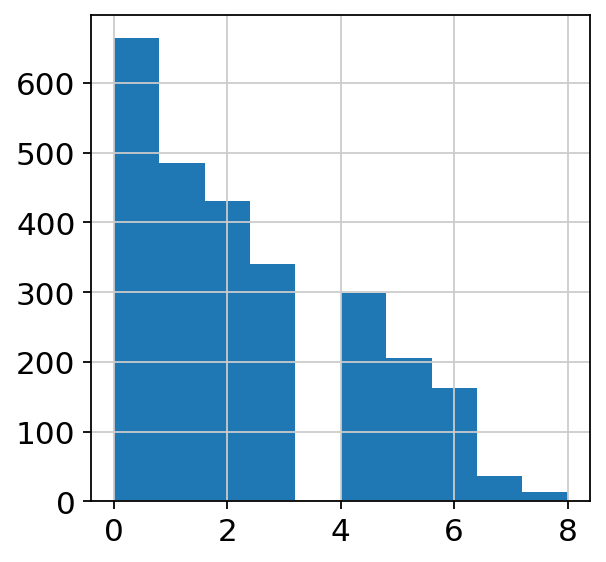

In [194]:
plt.hist(graph.y.max(axis=1).indices.tolist())

### data organisation 

In [224]:
import torch_geometric
from torch_geometric.data import Data, Batch

In [239]:
Asparse = connectivities2sparse(adata)
edge_index = edge_index_from_sparse(Asparse)
y = leiden2target_onehot(adata)
_data = Data(
    x=Asparse, 
    edge_index=edge_index, 
    y=y)

In [240]:
_data.num_nodes

2638